# Regresion Basica: Predecir eficiencia de gasolina

Este libro usa el set de datos clasico [Auto MPG](https://archive.ics.uci.edu/ml/datasets/auto+mpg) y construye un modelo para predecir el consumo de vehiculos de 1970 y 1980. Para hacer esto proveeremos el modelo con una descripcion de muchos automoviles de ese periodo. Esta descripcion incluye atributos como: Cilindros, desplazamiento, potencia y peso.

El objetivo de este ejercicio es predecir el target miles per galon (MPG), que vendría a representar las millas por galón de combustible.

Este ejemplo usa el API `tf.keras` , revise [Esta Guia](https://www.tensorflow.org/guide/keras) para obtener mas detalles.

In [2]:
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
import numpy as np  
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2024-02-23 13:11:04.331342: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.15.0


## El set de Datos de MPG

El set de datos esta disponible de el siguiente repositorio [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/).

### Obtenga los datos
Primero descargue el set de datos.

In [7]:
df = pd.read_csv('./auto-mpg.data', delim_whitespace=True, names=['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model_year', 'origin', 'car_name'])
df.head()   

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,car_name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino


In [8]:
df = df.drop('car_name', axis=1)
df.head()   

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


Importelo usando pandas.

### Limpia los datos

Trata los missings y variables categóricas

In [9]:
df.isnull().sum()       

mpg             0
cylinders       0
displacement    0
horsepower      0
weight          0
acceleration    0
model_year      0
origin          0
dtype: int64

In [10]:
# dummy origin
origin_dummies = pd.get_dummies(df['origin'])

# Rename 
origin_dummies.rename(columns={1:'USA', 2:'Europe', 3:'Japan'}, inplace=True) 

# Join 
df = df.join(origin_dummies)

df.head(20)

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,USA,Europe,Japan
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,1,0,0
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,1,0,0
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,1,0,0
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,1,0,0
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,1,0,0
5,15.0,8,429.0,198.0,4341.0,10.0,70,1,1,0,0
6,14.0,8,454.0,220.0,4354.0,9.0,70,1,1,0,0
7,14.0,8,440.0,215.0,4312.0,8.5,70,1,1,0,0
8,14.0,8,455.0,225.0,4425.0,10.0,70,1,1,0,0
9,15.0,8,390.0,190.0,3850.0,8.5,70,1,1,0,0


### Divide los datos en train y test

Ahora divida el set de datos en un set de entrenamiento y otro de pruebas. 80% para entrenamiento

Usaremos el set de pruebas en la evaluacion final de nuestro modelo.

NOTA: El resultado tienen que ser dos datasets

In [12]:
# Split data into train and test sets
# train_df contains 80% of rows sampled randomly for training
# test_df contains remaining 20% of rows for testing

train_df = df.sample(frac=0.8,random_state=0)
test_df = df.drop(train_df.index)

### Inspecciona los datos

Revise rapidamente la distribucion conjunta del dataset de entrenamiento mediante un grid de gráficos

/var/folders/m8/hp9mxxbj6dv9x3px18fy22_r0000gn/T/ipykernel_74151/621126171.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True)


<AxesSubplot: >

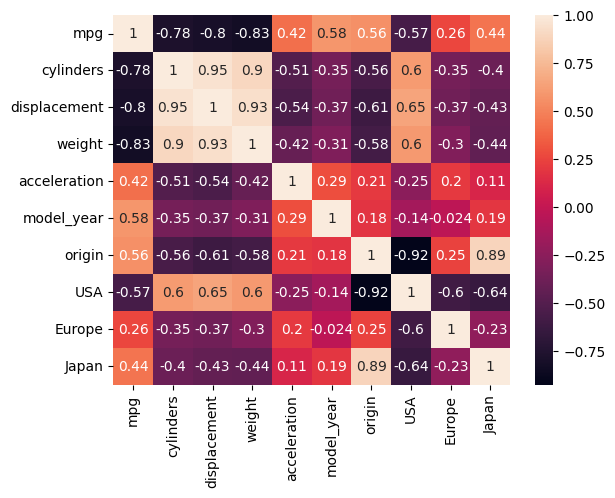

In [24]:
sns.heatmap(df.corr(), annot=True)

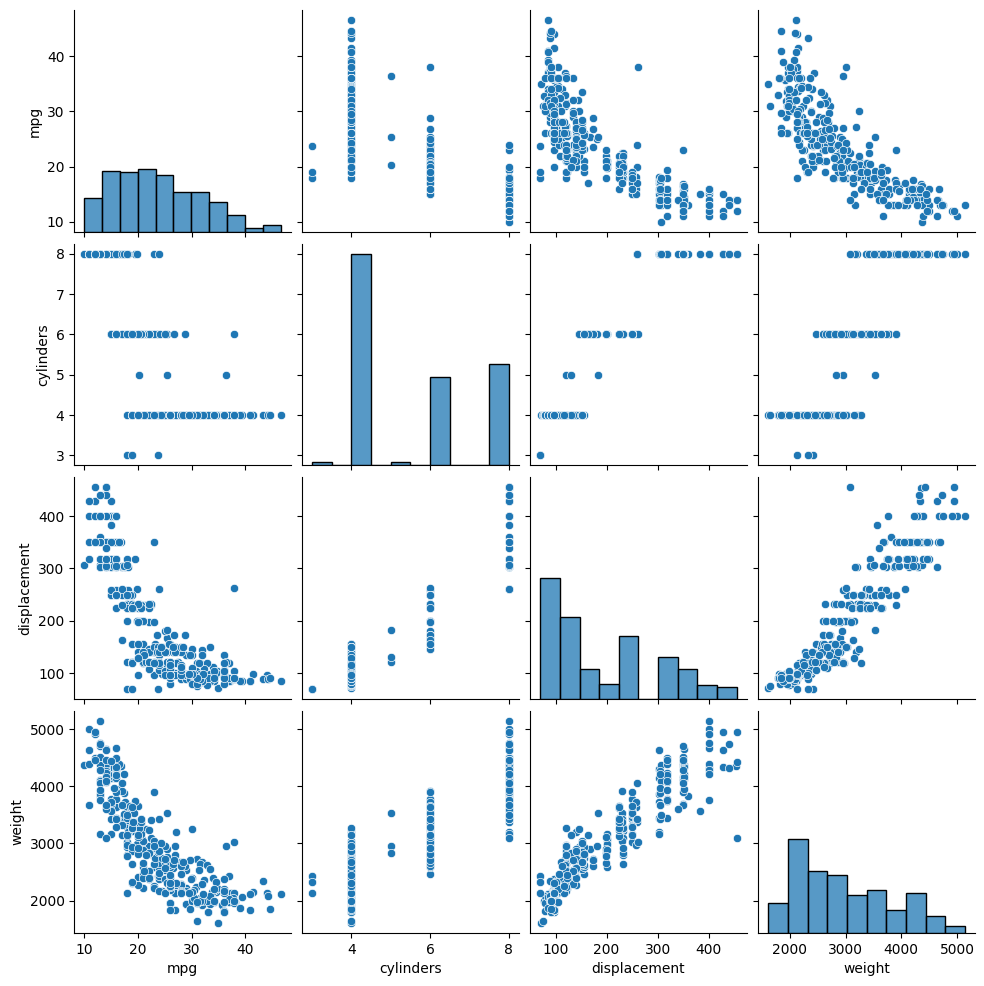

In [25]:
sns.pairplot(train_df[["mpg", "cylinders", "displacement", "weight"]], diag_kind="hist");

Tambien revise las estadisticas generales:

In [13]:
# Train statistics
statistic_train = train_df.describe()
statistic_train.pop("mpg")
statistic_train = statistic_train.transpose()
statistic_train

,count,mean,std,min,25%,50%,75%,max
cylinders,318.0,5.427673,1.682941,3.0,4.00,4.0,6.00,8.0
displacement,318.0,193.061321,103.812742,70.0,100.25,151.0,259.50,455.0
weight,318.0,2963.823899,844.749805,1613.0,2219.25,2792.5,3571.25,5140.0
acceleration,318.0,15.595912,2.796282,8.0,13.90,15.5,17.30,24.8
model_year,318.0,75.946541,3.705266,70.0,73.00,76.0,79.00,82.0
origin,318.0,1.553459,0.799430,1.0,1.00,1.0,2.00,3.0
USA,318.0,0.641509,0.480313,0.0,0.00,1.0,1.00,1.0
Europe,318.0,0.163522,0.370424,0.0,0.00,0.0,0.00,1.0
Japan,318.0,0.194969,0.396801,0.0,0.00,0.0,0.00,1.0


### Separa las features del target

Separe el target de las features.

In [14]:
train_labels = train_df.pop('mpg')
test_labels = test_df.pop('mpg')

### Estandariza los datos

Es una buena práctica estandarizar funciones que utilizan diferentes escalas y rangos. Aunque el modelo podría converger sin estandarizar, dificulta el entrenamiento y hace que el modelo resultante dependa de la elección de las unidades utilizadas en la entrada.

In [15]:
'''function standard() standardizes
mean of 0 and standard deviation of 1
'''

def standard(x):
  return (x - statistic_train['mean']) / statistic_train['std']

standard_train_data = standard(train_df)
standard_test_data = standard(test_df)

Estos datos estandarizados es lo que usaremos para entrenar el modelo.

## El modelo

### Construye el modelo

Construyamos nuestro modelo. Aquí, utilizaremos un modelo `secuencial` con dos capas ocultas densamente conectadas y una capa de salida que devuelve un único valor continuo.

Por tanto, tendrá tres capas. Una de entrada con activación relu. Otra hidden layer con activación relu y la de salida de regresión, que se compondrá de una única neurona. Pon las neuronas que consideres para las dos primeras capas.

Para el compile utiliza un loss='mse'.

optimizer = `tf.keras.optimizers.RMSprop(0.001)`

Y en metrics añade en una lista el `mae` y `mse`.

In [16]:
model = keras.Sequential([
layers.Dense(64, activation='relu', input_shape=[len(train_df.keys())]),
layers.Dense(64, activation='relu'),
layers.Dense(1)
])


model.compile(loss='mse',
              optimizer='adam',
              metrics=['mae', 'mse'])

In [17]:
train_df.shape

(318, 10)

### Inspeccione el modelo

Use el método `.summary` para imprimir una descripción simple del modelo

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                704       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4929 (19.25 KB)
Trainable params: 4929 (19.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Entrenar el modelo

Entrene el modelo para 1000 epochs y guarda los resultados del entrenamiento en una variable llamada `history`.
Emplea en el entrenamiento un 20% de los datos para validación, mediante el argumento `validation_split`.

NOTA: recuerda usar los datos normalizados.

In [20]:
history = model.fit(
                    standard_train_data, 
                    train_labels,
                    epochs=1000, 
                    validation_split=0.2,
                    verbose=0)

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type float).

Visualice el progreso de entrenamiento del modelo usando las estadísticas almacenadas en el objeto `history`.

In [21]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

NameError: name 'history' is not defined

¿Alguna conclusión respecto a este gráfico?

Añade un early stopping al modelo. Pon el argumento `callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)]` dentro del fit().

Después del entrenamiento utiliza la función del apartado anterior `plot_history(history)`.

Interpreta el gráfico

Veamos qué tan bien generaliza el modelo al usar el conjunto de **test**. Esto nos dice qué tan bien podemos esperar que el modelo prediga cuándo lo usamos en el mundo real. Utiliza el método `evaluate` con los datos de test normalizados y sus labels.

Con el método evaluate devolverá tres valores: loss, mae y mse.

Ahora prueba el modelo. Coge 10 ejemplos de train y llama a` model.predict`.

### Haz Predicciones

Dibuja en un scatter plot las predicciones de test vs sus true labels.

Parece que nuestro modelo predice razonablemente bien. Echemos un vistazo a la distribución de errores.

Representa los residuos en un histograma

No es del todo gaussiano, pero podríamos esperar eso porque el número de muestras es muy pequeño.

## Conclusion

Este cuaderno introdujo algunas técnicas para manejar un problema de regresión.

* El error cuadrático medio (MSE) es una función de pérdida común utilizada para problemas de regresión (se utilizan diferentes funciones de pérdida para problemas de clasificación).
* Del mismo modo, las métricas de evaluación utilizadas para la regresión difieren de la clasificación. Una métrica de regresión común es el error absoluto medio (MAE).
* Cuando las características de datos de entrada numéricos tienen valores con diferentes rangos, cada característica debe escalarse independientemente al mismo rango.
* Si no hay muchos datos de entrenamiento, una técnica es preferir una red pequeña con pocas capas ocultas para evitar el sobreajuste.
* La detención temprana es una técnica útil para evitar el sobreajuste.